In [1]:
import pandas as pd
import numpy as np
#import random
#import copy
import matplotlib.pyplot as plt
#import xgboost as xgb
from sklearn.ensemble import IsolationForest
#from sklearn.neighbors import LocalOutlierFactor
#from sklearn.preprocessing import RobustScaler
#from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import metrics
from catboost import CatBoostRegressor, Pool, cv

# Загрузим файл с признаками

In [2]:
features = pd.read_excel('C:\\Users\\dgalk\\shad_final_project\\features_rest_Russia.xlsx')

# Возьмем в рассмотрение пока 1-ую корзину

In [78]:
print("Кол-во объектов basket1: {0}".format(features["Basket2"].dropna().size))

Кол-во объектов basket1: 9947


Удалим из нее объекты, где Apharm = 1 и Nan

In [79]:
bask2 = features["Basket2"][features.Apharm == 0].dropna()
print("Итоговое кол-во объектов без Apharm=1: {0}".format(bask2.size))

Итоговое кол-во объектов без Apharm=1: 9217


Т.е. порядка 700 убрали из рассмотрения

Посмотрим на гистограмму распределения

In [5]:
def plot_hist(data, title=''):
    fig = plt.figure(figsize = (10,5))
    ax = fig.gca()
    data.plot.hist(grid=True, bins=20, ax=ax, rwidth=0.9, color='#607c8e')
    ax.set_title(title, fontsize=20)
    ax.set_ylabel('Частоты', fontsize=20)
    ax.set_xlabel('Объем корзины', fontsize=20)  

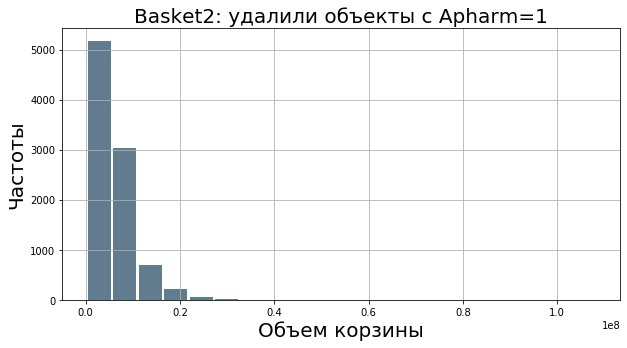

In [6]:
plot_hist(bask2, 'Basket2: удалили объекты с Apharm=1')

Построим график basket1 по возрастанию значений 

In [7]:
def plot_one_graphic_sorted(y, figsize=(10,5), linewidth=4, color='tab:brown', label=''):
    indices = np.argsort(y)
    x_plt = np.arange(0, y.size)
    y_plt = y.iloc[indices]
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x_plt, y_plt, color=color, linewidth=linewidth, label=label)
    ax.grid(linestyle='--')
    ax.legend()

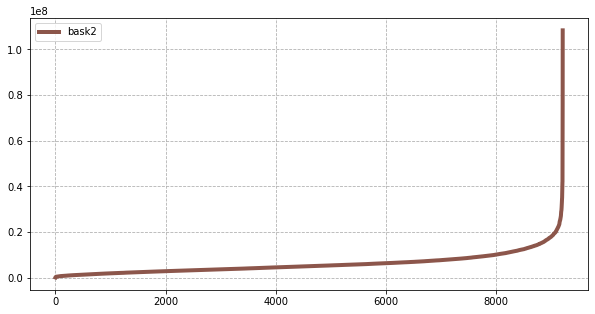

In [8]:
plot_one_graphic_sorted(bask2, label='bask2')

Собственно, видим то, что и на гистаграмме: ярко выраженный хвост с большими значениями. 

# Отсеивание признаков с помощью IsolationForest

Посмотрим, при каком random_state меньше всего и больше всего признаков отсеивается

In [9]:
rand_state_list = []

for random_state_ in range(0, 300):
    iso_forest = IsolationForest(random_state=random_state_).fit_predict(np.array(bask2).reshape(-1, 1))
    rand_state_list.append(np.abs(iso_forest[np.where(iso_forest == -1)].sum()))
    
rand_state_min = min((val, idx) for idx, val in enumerate(rand_state_list))
rand_state_max = max((val, idx) for idx, val in enumerate(rand_state_list))

print("Min: {0} --- {1}".format(rand_state_min[1], rand_state_min[0]))
print("Max: {0} --- {1}".format(rand_state_max[1], rand_state_max[0]))

Min: 92 --- 1507
Max: 292 --- 2628


In [10]:
# минимум
iso_forest = IsolationForest(random_state=92).fit_predict(np.array(bask2).reshape(-1, 1))
bask2_isoforest_min = bask2.iloc[np.where(iso_forest == 1)]
print("Итоговое кол-во объектов: {0}".format(bask2_isoforest_min.size))

Итоговое кол-во объектов: 7710


Посмотрим на то, что построили

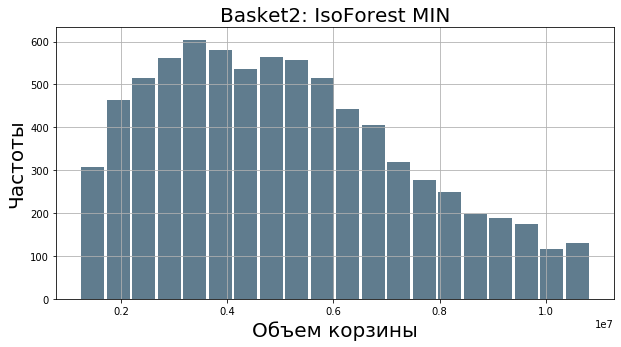

In [11]:
plot_hist(bask2_isoforest_min, title='Basket2: IsoForest MIN')

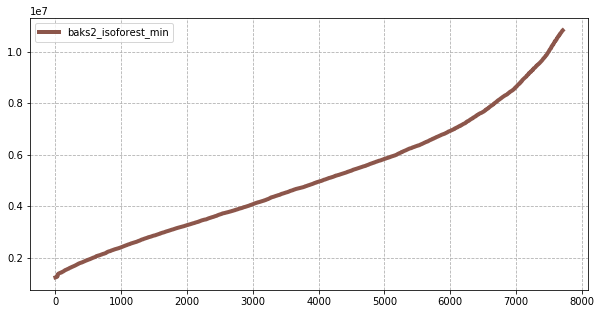

In [13]:
plot_one_graphic_sorted(bask2_isoforest_min, label='baks2_isoforest_min')

# Признаки, которые будем рассматривать

Полный список

In [80]:
col_full = ['BrandCodes', 'BrickCode', 
           'Cash', 'Card', 'Internet', 'Bank',
           'population', 'VRP', 
           'NumHos','NumAmb', 'NumPhc',
           'APT', 'PCP', 'PHK', 'PHN', 'PST',
           'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14',
           'top_brand_31', 'top_brand_10', 'top_brand_84', 'top_brand_17', 'top_brand_2', 
           'top_sales_1', 'top_sales_0', 'top_sales_11', 'top_sales_31', 'top_sales_14',
           'top_sales_84', 'top_sales_41', 'top_sales_7', 'top_sales_9', 'top_sales_10',
           'top_sales_133', 'top_sales_17', 'top_sales_34', 'top_sales_32', 'top_sales_39',
           'Metro_dist', 'Metro_num',   
           'АО', 'Респ', 'край', 'обл', 
           'аллея', 'б-р', 'городок',
           'дор', 'заезд', 'кв-л', 'км', 'линия', 'мкр', 'наб', 'нп', 'п', 'парк',
           'пер', 'пл', 'пр-кт', 'проезд', 'просека', 'рзд', 'ряды', 'сл', 'спуск',
           'тер', 'тракт', 'туп', 'ул', 'уч-к', 'ш', 
           'Rate123', 'Rate1', 'Rate2', 'Rate3', 'Rate_mean',
           'weekdays_work_time',
           'weekend_work_time',  
           'is_work_time_almost_24_7',
           #'uniq_sku_mean_median3', 'sell_mean_median3', 'avg_sell_sku_median3',
           'uniq_sku_mean_summer_median3', 
           'uniq_sku_mean_autumn_median3',
           'uniq_sku_mean_winter_median3', 
           'uniq_sku_mean_spring_median3',
           'sell_mean_summer_median3', 
           'sell_mean_autumn_median3', 
           'sell_mean_winter_median3', 
           'sell_mean_spring_median3',
           'avg_sell_sku_summer_median3',
           'avg_sell_sku_autumn_median3',
           'avg_sell_sku_winter_median3',
           'avg_sell_sku_spring_median3',
           'num_pharm', 'region_popul', 'soul_on_pharm',
           'debcred', 'pens_proc', 'prod_basket', 'pharm_basket', 
]

# Первый baseline

In [81]:
def get_XY(data, col, random_state=123):
    
    X = features.loc[data.index, col]
    y = data[X.index]
    
    X_train, X_test, y_train, y_test = \
                train_test_split(X, y, 
                                 test_size=0.2,
                                 random_state=random_state,
                                 shuffle=True)
    
    return X_train, X_test, y_train, y_test

In [82]:
bask2_median = np.round(bask2_isoforest_min.median())
print("Медиана bask2_isoforest_min: {0}".format(bask2_median))

Медиана bask2_isoforest_min: 4820553.0


In [23]:
def print_best_test_results(model, median):
    print("====================")
    print("    test-results")
    print("====================")
    
    print("RMSE:\t{0}".format(np.round(model.get_best_score()['validation']['RMSE'])))
    print("MAE:\t{0} ({1}%)".format(np.round(model.get_best_score()['validation']['MAE']), 
                                   np.round(model.get_best_score()['validation']['MAE'] / median * 100)))
    print("R2:\t{0}".format(np.round(model.get_best_score()['validation']['R2'], 3)))
    print("MAPE:\t{0}".format(np.round(model.get_best_score()['validation']['MAPE'], 3)))

In [24]:
def cv_res(X, y, median, iterations=1500, depth=7, lr=0.05, l2=3):
    cv_dataset = Pool(data=X, label=y)

    params = {"iterations": iterations,
              "depth": depth,
              "learning_rate": lr,
              "l2_leaf_reg": l2,
              "loss_function": "RMSE",
              "custom_metric": ['R2', 'RMSE', 'MAE', 'MAPE'],
              "verbose": False}

    scores = cv(cv_dataset,
                params,
                fold_count=5)
    
    index_min_rmse = np.argmin(scores['test-RMSE-mean'])

    print("====================")
    print("  cross-validation")
    print("====================")

    rmse_mean = scores['test-RMSE-mean'][index_min_rmse]
    rmse_std = scores['test-RMSE-std'][index_min_rmse]
    print("RMSE:\t{0} +- {1}".format(np.round(rmse_mean), np.round(2 * rmse_std)))

    mae_mean = scores['test-MAE-mean'][index_min_rmse]
    mae_std = scores['test-MAE-std'][index_min_rmse]
    print("MAE:\t{0} +- {1}\t({2} %)".format(np.round(mae_mean), np.round(2 * mae_std),
         np.round(mae_mean / median * 100)))

    r2_mean = scores['test-R2-mean'][index_min_rmse]
    r2_std = scores['test-R2-std'][index_min_rmse]
    print("R2:\t{0} +- {1}".format(np.round(r2_mean, 3), np.round(2 * r2_std, 3)))

    mape_mean = scores['test-MAPE-mean'][index_min_rmse]
    mape_std = scores['test-MAPE-std'][index_min_rmse]
    print("MAPE:\t{0} +- {1}".format(np.round(mape_mean, 3), np.round(2 * mape_std, 3)))
    
    return index_min_rmse

In [25]:
def plot_train_test_metrics(model):
    x_plt = np.arange(1, model.get_params()['iterations'] + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(221)
    plt.plot(x_plt, model.evals_result_['learn']['RMSE'], 'r--', label = 'train')
    plt.plot(x_plt, model.evals_result_['validation']['RMSE'], label='test')
    plt.grid(linestyle='--')
    plt.xlabel('iteration', fontsize=12)
    plt.title('RMSE', loc='right', fontsize=12)
    plt.legend()

    plt.subplot(222)
    plt.plot(x_plt, model.evals_result_['learn']['MAE'], 'r--', label = 'train')
    plt.plot(x_plt, model.evals_result_['validation']['MAE'], label='test')
    plt.grid(linestyle='--')
    plt.xlabel('iteration', fontsize=12)
    plt.title('MAE', loc='right', fontsize=12)
    plt.legend()
    
    plt.subplot(223)
    plt.plot(x_plt, model.evals_result_['learn']['R2'], 'r--', label = 'train')
    plt.plot(x_plt, model.evals_result_['validation']['R2'], label='test')
    plt.grid(linestyle='--')
    plt.xlabel('iteration', fontsize=12)
    plt.title('R2', loc='right', fontsize=12)
    plt.legend()
    
    plt.subplot(224)
    plt.plot(x_plt, model.evals_result_['learn']['MAPE'], 'r--', label = 'train')
    plt.plot(x_plt, model.evals_result_['validation']['MAPE'], label='test')
    plt.grid(linestyle='--')
    plt.xlabel('iteration', fontsize=12)
    plt.title('MAPE', loc='right', fontsize=12)
    plt.legend()
    
    plt.show()

In [26]:
X_train, X_test, y_train, y_test = get_XY(bask2_isoforest_min, col_full, random_state=123)

eval_dataset = Pool(X_test, y_test)

model = CatBoostRegressor(iterations=2000,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

print_best_test_results(model, bask2_median)

    test-results
RMSE:	1334725.0
MAE:	955900.0 (20.0%)
R2:	0.644
MAPE:	0.23


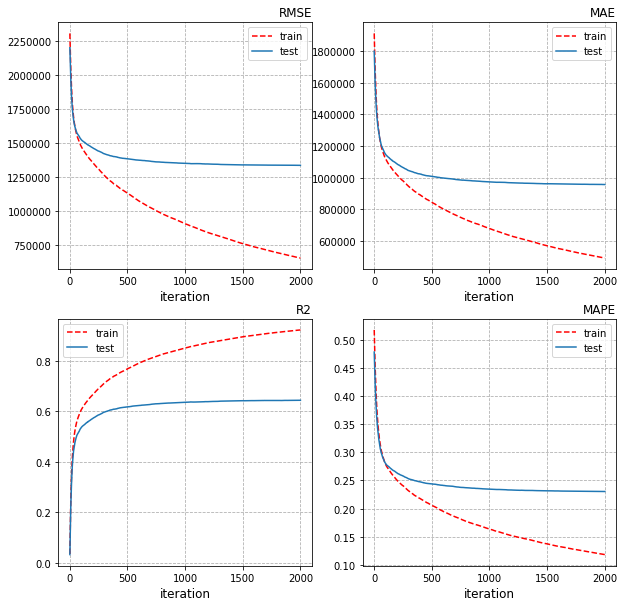

In [27]:
plot_train_test_metrics(model)

# Gridsearch

In [28]:
X_train, X_test, y_train, y_test = get_XY(bask2_isoforest_min, col_full, random_state=123)

model = CatBoostRegressor(custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

grid = {'learning_rate': [0.03, 0.05, 0.07, 0.1],
        'depth': [4, 5, 6, 7, 8],
        'l2_leaf_reg': [0, 1, 2, 3, 4]}

grid_search_result = model.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train,
                                       cv=5,
                                       verbose=False,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 1394782.006
bestIteration = 997


bestTest = 1380032.381
bestIteration = 998


bestTest = 1379760.99
bestIteration = 995


bestTest = 1368674.511
bestIteration = 893


bestTest = 1399636.685
bestIteration = 995


bestTest = 1374124.891
bestIteration = 986


bestTest = 1374228.47
bestIteration = 997


bestTest = 1372083.83
bestIteration = 904


bestTest = 1398364.101
bestIteration = 999


bestTest = 1378918.718
bestIteration = 933


bestTest = 1367796.839
bestIteration = 998


bestTest = 1368259.341
bestIteration = 989


bestTest = 1408038.919
bestIteration = 999


bestTest = 1377184.063
bestIteration = 999


bestTest = 1375673.201
bestIteration = 998


bestTest = 1365897.521
bestIteration = 887


bestTest = 1406223.165
bestIteration = 996


bestTest = 1385170.533
bestIteration = 994


bestTest = 1379424.826
bestIteration = 939


bestTest = 1376254.74
bestIteration = 872


bestTest = 1365818.841
bestIteration = 999


bestTest = 1348708.663
bestIteration = 993


bestTest = 13

KeyboardInterrupt: 

Полученные параметры (возьмем такие):

<li>depth = 7
<li>learning_rate = 0.05
<li>l2_leaf_reg = 3
    
Посмотрим качество на тесте и кросс-валидации при этих параметрах

In [32]:
X_train, X_test, y_train, y_test = get_XY(bask2_isoforest_min, col_full, random_state=123)

eval_dataset = Pool(X_test, y_test)

model = CatBoostRegressor(iterations=2000,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

print_best_test_results(model, bask2_median)

    test-results
RMSE:	1320145.0
MAE:	947319.0 (20.0%)
R2:	0.652
MAPE:	0.228


In [36]:
best_iter_ = cv_res(X_train, y_train, bask2_median, 
                   iterations=2000, 
                   depth=7, 
                   lr=0.05, 
                   l2=3)

  cross-validation
RMSE:	1350349.0 +- 38128.0
MAE:	952541.0 +- 29942.0	(20.0 %)
R2:	0.669 +- 0.013
MAPE:	0.23 +- 0.018


1948

Примерно одинаково

Посмотрим на значимость признаков

In [37]:
def get_and_draw_importances(X_train, importances, figsize=(10,25)):
  indices = np.argsort(importances)
  plt.figure(figsize=figsize)
  plt.title("Feature importances")
  plt.barh(range(X_train.shape[1]), importances[indices], color="r", align="center")
  plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
  plt.ylim([-1, X_train.shape[1]])
  plt.show()
  return X_train.columns[indices]

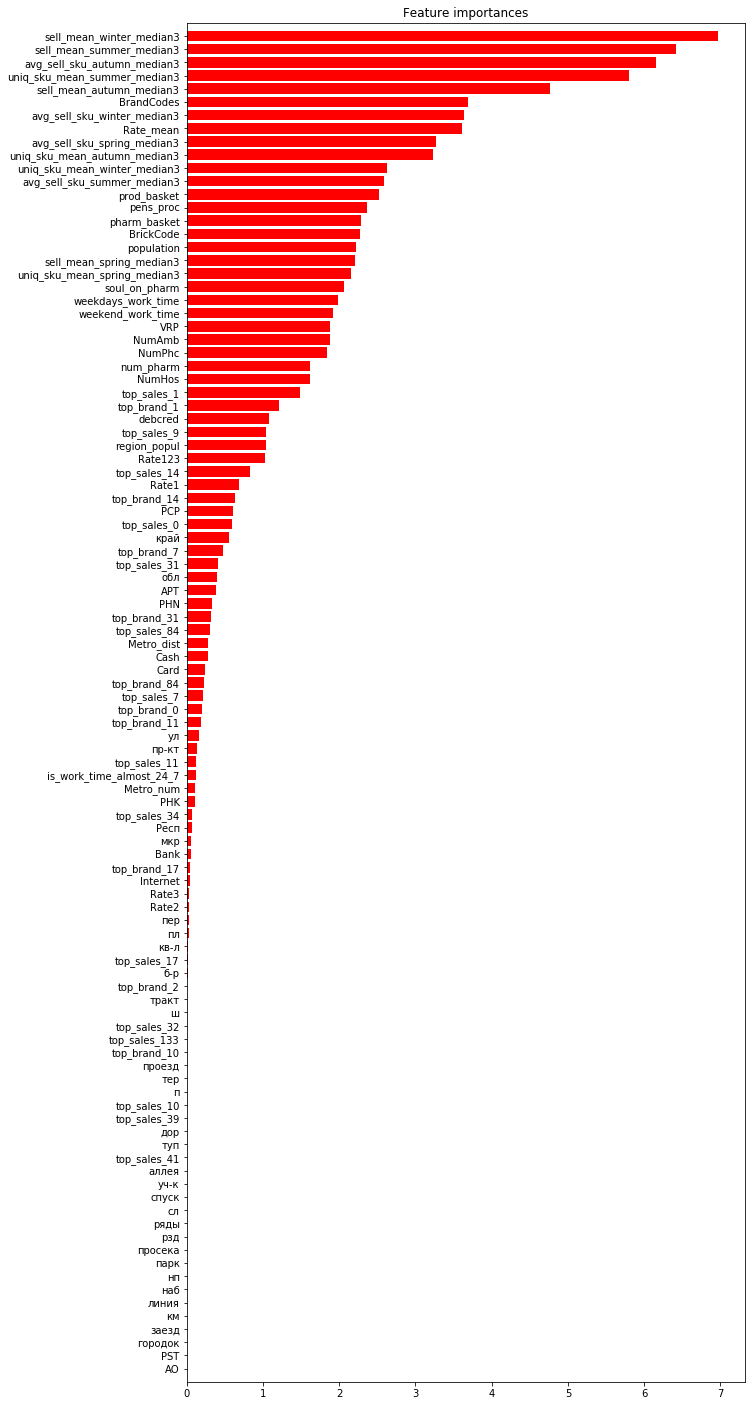

In [38]:
importances_ = get_and_draw_importances(X_train, model.feature_importances_)

# Уменьшение кол-ва признаков

**Уменьшим до 50**

In [40]:
X_train, X_test, y_train, y_test = get_XY(bask2_isoforest_min, col_full, random_state=123)

model = CatBoostRegressor(iterations=1500,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          verbose=0)

selector = RFE(model, n_features_to_select=50, step=1, verbose=0)
selector = selector.fit(X_train, y_train)

col_50_features = [col_full[i] for i, b in enumerate(selector.support_) if b]
print(col_50_features)

['BrandCodes', 'BrickCode', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'PHN', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_84', 'top_sales_1', 'top_sales_0', 'top_sales_31', 'top_sales_14', 'top_sales_7', 'top_sales_9', 'Metro_dist', 'край', 'обл', 'ул', 'Rate123', 'Rate1', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket']


Ну и чтобы не перезапускать в след. раз

In [45]:
col_50_features = ['BrandCodes', 'BrickCode', 'population', 'VRP', 
                   'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'PHN', 
                   'top_brand_1', 'top_brand_11', 'top_brand_7', 
                   'top_brand_14', 'top_brand_31', 'top_brand_84', 
                   'top_sales_1', 'top_sales_0', 'top_sales_31', 
                   'top_sales_14', 'top_sales_7', 'top_sales_9', 
                   'Metro_dist', 'край', 'обл', 'ул', 'Rate123', 
                   'Rate1', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 
                   'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 
                   'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 
                   'sell_mean_summer_median3', 'sell_mean_autumn_median3', 
                   'sell_mean_winter_median3', 'sell_mean_spring_median3', 
                   'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 
                   'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3',
                   'num_pharm', 'region_popul', 'soul_on_pharm', 
                   'debcred', 'pens_proc', 'prod_basket', 'pharm_basket']

**Уменьшим до 70**

In [41]:
X_train, X_test, y_train, y_test = get_XY(bask2_isoforest_min, col_full, random_state=123)

model = CatBoostRegressor(iterations=1500,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          verbose=0)

selector = RFE(model, n_features_to_select=70, step=1, verbose=0)
selector = selector.fit(X_train, y_train)

col_70_features = [col_full[i] for i, b in enumerate(selector.support_) if b]
print(col_70_features)

['BrandCodes', 'BrickCode', 'Cash', 'Card', 'Internet', 'Bank', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'PHK', 'PHN', 'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_84', 'top_brand_17', 'top_sales_1', 'top_sales_0', 'top_sales_11', 'top_sales_31', 'top_sales_14', 'top_sales_84', 'top_sales_7', 'top_sales_9', 'top_sales_17', 'top_sales_34', 'Metro_dist', 'Metro_num', 'Респ', 'край', 'обл', 'кв-л', 'мкр', 'пер', 'пл', 'пр-кт', 'ул', 'Rate123', 'Rate1', 'Rate2', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'is_work_time_almost_24_7', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_p

In [46]:
col_70_features = ['BrandCodes', 'BrickCode', 'Cash', 'Card', 'Internet', 'Bank', 
                   'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 
                   'APT', 'PCP', 'PHK', 'PHN', 
                   'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 
                   'top_brand_14', 'top_brand_31', 'top_brand_84', 'top_brand_17', 
                   'top_sales_1', 'top_sales_0', 'top_sales_11', 'top_sales_31', 
                   'top_sales_14', 'top_sales_84', 'top_sales_7', 'top_sales_9', 
                   'top_sales_17', 'top_sales_34', 
                   'Metro_dist', 'Metro_num', 
                   'Респ', 'край', 'обл', 'кв-л', 'мкр', 'пер', 'пл', 'пр-кт', 'ул', 
                   'Rate123', 'Rate1', 'Rate2', 'Rate_mean', 
                   'weekdays_work_time', 'weekend_work_time', 'is_work_time_almost_24_7', 
                   'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 
                   'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 
                   'sell_mean_summer_median3', 'sell_mean_autumn_median3', 
                   'sell_mean_winter_median3', 'sell_mean_spring_median3', 
                   'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 
                   'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 
                   'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 
                   'pens_proc', 'prod_basket', 'pharm_basket']

**Уменьшим до 40**

In [42]:
X_train, X_test, y_train, y_test = get_XY(bask2_isoforest_min, col_50_features, random_state=123)

model = CatBoostRegressor(iterations=1500,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          verbose=0)

selector = RFE(model, n_features_to_select=40, step=1, verbose=0)
selector = selector.fit(X_train, y_train)

col_40_features = [col_50_features[i] for i, b in enumerate(selector.support_) if b]
print(col_40_features)

['BrandCodes', 'BrickCode', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'PCP', 'top_brand_1', 'top_brand_14', 'top_brand_31', 'top_sales_1', 'top_sales_0', 'top_sales_14', 'top_sales_9', 'обл', 'Rate123', 'Rate1', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket']


In [47]:
col_40_features = ['BrandCodes', 'BrickCode', 'population', 'VRP', 
                   'NumHos', 'NumAmb', 'NumPhc', 'PCP', 
                   'top_brand_1', 'top_brand_14', 'top_brand_31', 
                   'top_sales_1', 'top_sales_0', 'top_sales_14', 'top_sales_9', 
                   'обл', 'Rate123', 'Rate1', 'Rate_mean', 
                   'weekdays_work_time', 'weekend_work_time', 
                   'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 
                   'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 
                   'sell_mean_summer_median3', 'sell_mean_autumn_median3', 
                   'sell_mean_winter_median3', 'sell_mean_spring_median3', 
                   'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 
                   'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 
                   'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 
                   'pens_proc', 'prod_basket', 'pharm_basket']

**Уменьшим до 35**

In [43]:
X_train, X_test, y_train, y_test = get_XY(bask2_isoforest_min, col_40_features, random_state=123)

model = CatBoostRegressor(iterations=1500,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          verbose=0)

selector = RFE(model, n_features_to_select=35, step=1, verbose=0)
selector = selector.fit(X_train, y_train)

col_35_features = [col_40_features[i] for i, b in enumerate(selector.support_) if b]
print(col_35_features)

['BrandCodes', 'BrickCode', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'top_brand_1', 'top_brand_14', 'top_sales_1', 'top_sales_0', 'top_sales_9', 'Rate123', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket']


In [48]:
col_35_features = ['BrandCodes', 'BrickCode', 'population', 'VRP', 
                   'NumHos', 'NumAmb', 'NumPhc', 
                   'top_brand_1', 'top_brand_14', 'top_sales_1', 'top_sales_0', 'top_sales_9', 
                   'Rate123', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 
                   'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 
                   'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 
                   'sell_mean_summer_median3', 'sell_mean_autumn_median3', 
                   'sell_mean_winter_median3', 'sell_mean_spring_median3', 
                   'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 
                   'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 
                   'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 
                   'pens_proc', 'prod_basket', 'pharm_basket']

**Уменьшим до 30**

In [44]:
X_train, X_test, y_train, y_test = get_XY(bask2_isoforest_min, col_35_features, random_state=123)

model = CatBoostRegressor(iterations=1500,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          verbose=0)

selector = RFE(model, n_features_to_select=30, step=1, verbose=0)
selector = selector.fit(X_train, y_train)

col_30_features = [col_35_features[i] for i, b in enumerate(selector.support_) if b]
print(col_30_features)

['BrandCodes', 'BrickCode', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'top_brand_14', 'top_sales_1', 'Rate123', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'soul_on_pharm', 'pens_proc', 'prod_basket', 'pharm_basket']


In [49]:
col_30_features = ['BrandCodes', 'BrickCode', 'population', 'VRP', 
                   'NumHos', 'NumAmb', 'NumPhc', 
                   'top_brand_14', 'top_sales_1', 'Rate123', 'Rate_mean', 
                   'weekdays_work_time', 'weekend_work_time', 
                   'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 
                   'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 
                   'sell_mean_summer_median3', 'sell_mean_autumn_median3', 
                   'sell_mean_winter_median3', 'sell_mean_spring_median3', 
                   'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 
                   'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 
                   'num_pharm', 'soul_on_pharm', 'pens_proc', 'prod_basket', 'pharm_basket']

**Попробуем полученный сокращенный сет признаков с теми же гиперпараметрами**

In [51]:
X_train, X_test, y_train, y_test = get_XY(bask2_isoforest_min, col_70_features, random_state=123)

eval_dataset = Pool(X_test, y_test)

model = CatBoostRegressor(iterations=2000,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

print("70 признаков")
print_best_test_results(model, bask2_median)

best_iter_ = cv_res(X_train, y_train, bask2_median, 
                   iterations=1500, 
                   depth=7, 
                   lr=0.05, 
                   l2=3)

70 признаков
    test-results
RMSE:	1328468.0
MAE:	952899.0 (20.0%)
R2:	0.647
MAPE:	0.23
  cross-validation
RMSE:	1347399.0 +- 33190.0
MAE:	951216.0 +- 25501.0	(20.0 %)
R2:	0.67 +- 0.007
MAPE:	0.23 +- 0.017


In [52]:
X_train, X_test, y_train, y_test = get_XY(bask2_isoforest_min, col_50_features, random_state=123)

eval_dataset = Pool(X_test, y_test)

model = CatBoostRegressor(iterations=2000,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

print("50 признаков")
print_best_test_results(model, bask2_median)

50 признаков
    test-results
RMSE:	1328109.0
MAE:	955482.0 (20.0%)
R2:	0.648
MAPE:	0.23


In [53]:
X_train, X_test, y_train, y_test = get_XY(bask2_isoforest_min, col_40_features, random_state=123)

eval_dataset = Pool(X_test, y_test)

model = CatBoostRegressor(iterations=2000,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

print("40 признаков")
print_best_test_results(model, bask2_median)

40 признаков
    test-results
RMSE:	1330989.0
MAE:	952594.0 (20.0%)
R2:	0.646
MAPE:	0.229


In [54]:
X_train, X_test, y_train, y_test = get_XY(bask2_isoforest_min, col_35_features, random_state=123)

eval_dataset = Pool(X_test, y_test)

model = CatBoostRegressor(iterations=2000,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

print("35 признаков")
print_best_test_results(model, bask2_median)

35 признаков
    test-results
RMSE:	1336056.0
MAE:	958480.0 (20.0%)
R2:	0.643
MAPE:	0.231


In [55]:
X_train, X_test, y_train, y_test = get_XY(bask2_isoforest_min, col_30_features, random_state=123)

eval_dataset = Pool(X_test, y_test)

model = CatBoostRegressor(iterations=2000,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

print("30 признаков")
print_best_test_results(model, bask2_median)

30 признаков
    test-results
RMSE:	1331522.0
MAE:	951619.0 (20.0%)
R2:	0.646
MAPE:	0.229


При 70 признаках хороший результат

**Построим график теста и предсказания**

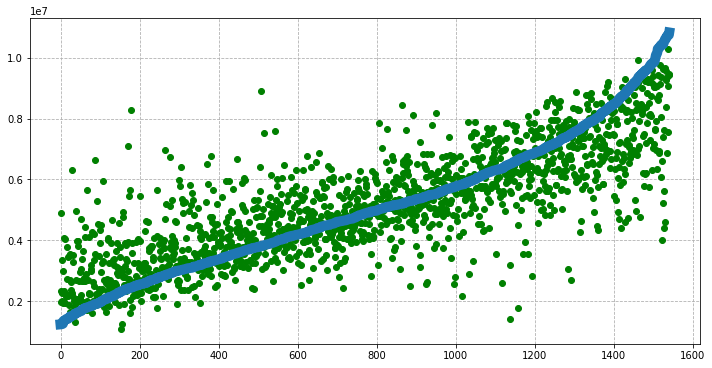

In [56]:
y_pred = model.predict(X_test)
indices = np.argsort(y_test)

x_plt = np.arange(0, y_test.size)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x_plt, y_pred[indices], 'go')
ax.plot(x_plt, y_test.iloc[indices], color='tab:blue', linewidth=10)
ax.grid(linestyle='--')

# Теперь возьмем только города миллионники

In [57]:
index_big_cities = []
for i, reg in enumerate(features.OKBrickL3):
    if "новосибирск г" in reg.lower() and "новосибирская" in reg.lower():
        index_big_cities.append(i)
    if "екатеринбург" in reg.lower():
        index_big_cities.append(i)
    if "нижний новгород" in reg.lower():
        index_big_cities.append(i)
    if "казань" in reg.lower():
        index_big_cities.append(i)
    if "челябинск г" in reg.lower() and "челябинская" in reg.lower():
        index_big_cities.append(i)
    if "омск г" in reg.lower() and "омская" in reg.lower() and "томск" not in reg.lower():
        index_big_cities.append(i)
    if "самара" in reg.lower():
        index_big_cities.append(i)
    if "ростов-на-дону" in reg.lower():
        index_big_cities.append(i)
    if "уфа г" in reg.lower():
        index_big_cities.append(i)
    if "красноярск г" in reg.lower():
        index_big_cities.append(i)
    if "воронеж г" in reg.lower() and "нововоронеж" not in reg.lower():
        index_big_cities.append(i)
    if "пермь" in reg.lower():
        index_big_cities.append(i)
    if "волгоград г" in reg.lower():
        index_big_cities.append(i) 
        
print("Кол-во городов-миллионников: {}".format(len(index_big_cities)))

Кол-во городов-миллионников: 8477


In [61]:
bask2_big_cities = features.loc[index_big_cities, "Basket2"][features.Apharm == 0].dropna()
print("Кол-во объектов в выборке: {0}".format(bask2_big_cities.size))

Кол-во объектов в выборке: 1638


Итого осталось: 1342


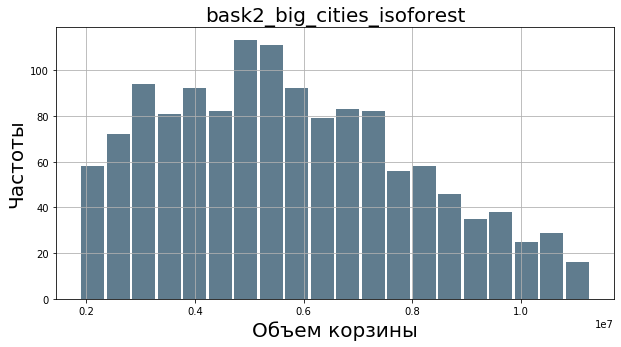

In [62]:
iso_forest = IsolationForest(random_state=92).fit_predict(np.array(bask2_big_cities).reshape(-1, 1))
bask2_big_cities_isoforest = bask2_big_cities.iloc[np.where(iso_forest == 1)]
print("Итого осталось: {0}".format(bask2_big_cities_isoforest.size))
plot_hist(bask2_big_cities_isoforest, 'bask2_big_cities_isoforest')

In [63]:
bask2_median_ = bask2_big_cities_isoforest.median()
print("bask2_big_cities_isoforest медиана: {0}".format(np.round(bask2_median_)))

bask2_big_cities_isoforest медиана: 5474489.0


In [64]:
X_train, X_test, y_train, y_test = get_XY(bask2_big_cities_isoforest, col_70_features, random_state=123)

eval_dataset = Pool(X_test, y_test)

model = CatBoostRegressor(iterations=1500,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

print_best_test_results(model, bask2_median_)

best_iter_ = cv_res(X_train, y_train, bask2_median_)

    test-results
RMSE:	1423472.0
MAE:	1026883.0 (19.0%)
R2:	0.604
MAPE:	0.197
  cross-validation
RMSE:	1332421.0 +- 101261.0
MAE:	991746.0 +- 64829.0	(18.0 %)
R2:	0.652 +- 0.039
MAPE:	0.188 +- 0.013


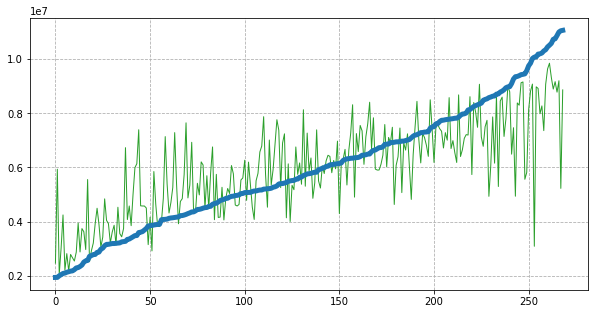

In [66]:
y_pred = model.predict(X_test)
indices = np.argsort(y_test)

x_plt = np.arange(0, y_test.size)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_plt, y_pred[indices], color='tab:green', linewidth=1)
ax.plot(x_plt, y_test.iloc[indices], color='tab:blue', linewidth=5)
ax.grid(linestyle='--')

# Финал по всем аптекам

Возьмем чуть другие гиперпараметры

In [257]:
X_train, X_test, y_train, y_test = get_XY(bask1_isoforest_min, col_full, random_state=123)

bask1_median = bask1_isoforest_min.median()

eval_dataset = Pool(X_test, y_test)

best_iter_ = cv_res(X_train, y_train, iterations=1500, depth=8, lr=0.03, l2=1)

model = CatBoostRegressor(iterations=best_iter_,
                          depth=8,
                          learning_rate=0.03,
                          l2_leaf_reg=1,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

y_pred = model.predict(X_test)

print("====================")
print("    test-results")
print("====================")
    
print("RMSE:\t{0}".format(np.round(model.evals_result_['validation']['RMSE'][-1])))
print("MAE:\t{0}".format(np.round(model.evals_result_['validation']['MAE'][-1])))
print("R2:\t{0}".format(np.round(model.evals_result_['validation']['R2'][-1], 3)))
print("MAPE:\t{0}".format(np.round(model.evals_result_['validation']['MAPE'][-1], 3)))

  cross-validation
RMSE:	1742619.0 +- 46191.0
MAE:	1288090.0 +- 33134.0	(28.0 %)
R2:	0.608 +- 0.01
MAPE:	0.339 +- 0.023
    test-results
RMSE:	1744322.0
MAE:	1262927.0
R2:	0.604
MAPE:	0.33


In [69]:
bask3 = features["Basket3"][features.Apharm == 0].dropna()

iso_forest = IsolationForest(random_state=84).fit_predict(np.array(bask3).reshape(-1, 1))
bask3_isoforest_min = bask3.iloc[np.where(iso_forest == 1)]
print("Итоговое кол-во объектов: {0}".format(bask3_isoforest_min.size))

Итоговое кол-во объектов: 7405


In [71]:
X_train, X_test, y_train, y_test = get_XY(bask3_isoforest_min, col_full, random_state=123)

bask3_median = bask3_isoforest_min.median()

eval_dataset = Pool(X_test, y_test)

best_iter_ = cv_res(X_train, y_train, bask3_median, iterations=1500, depth=7, lr=0.05, l2=3)

model = CatBoostRegressor(iterations=best_iter_,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

y_pred = model.predict(X_test)

print("====================")
print("    test-results")
print("====================")
    
print("RMSE:\t{0}".format(np.round(model.evals_result_['validation']['RMSE'][-1])))
print("MAE:\t{0}".format(np.round(model.evals_result_['validation']['MAE'][-1])))
print("R2:\t{0}".format(np.round(model.evals_result_['validation']['R2'][-1], 3)))
print("MAPE:\t{0}".format(np.round(model.evals_result_['validation']['MAPE'][-1], 3)))

  cross-validation
RMSE:	203128.0 +- 7819.0
MAE:	147691.0 +- 8457.0	(32.0 %)
R2:	0.651 +- 0.029
MAPE:	0.386 +- 0.036
    test-results
RMSE:	208463.0
MAE:	151761.0
R2:	0.645
MAPE:	0.425


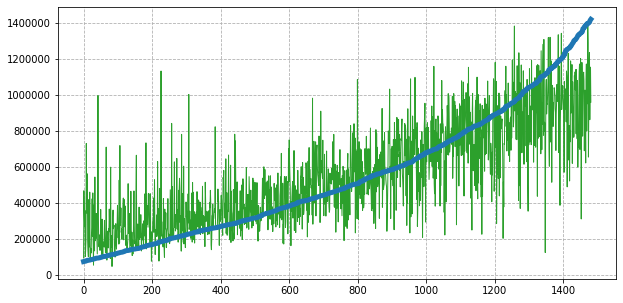

In [74]:
y_pred = model.predict(X_test)
indices = np.argsort(y_test)

x_plt = np.arange(0, y_test.size)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_plt, y_pred[indices], color='tab:green', linewidth=1)
ax.plot(x_plt, y_test.iloc[indices], color='tab:blue', linewidth=5)
ax.grid(linestyle='--')

In [83]:
X_train, X_test, y_train, y_test = get_XY(bask2, col_full, random_state=123)

eval_dataset = Pool(X_test, y_test)

best_iter_ = cv_res(X_train, y_train, bask2.median(), iterations=2000, depth=7, lr=0.05, l2=3)

model = CatBoostRegressor(iterations=best_iter_,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

y_pred = model.predict(X_test)

print("====================")
print("    test-results")
print("====================")
    
print("RMSE:\t{0}".format(np.round(model.evals_result_['validation']['RMSE'][-1])))
print("MAE:\t{0}".format(np.round(model.evals_result_['validation']['MAE'][-1])))
print("R2:\t{0}".format(np.round(model.evals_result_['validation']['R2'][-1], 3)))
print("MAPE:\t{0}".format(np.round(model.evals_result_['validation']['MAPE'][-1], 3)))

  cross-validation
RMSE:	2453952.0 +- 599641.0
MAE:	1351294.0 +- 78937.0	(27.0 %)
R2:	0.698 +- 0.082
MAPE:	0.322 +- 0.024
    test-results
RMSE:	2976275.0
MAE:	1321861.0
R2:	0.643
MAPE:	0.308


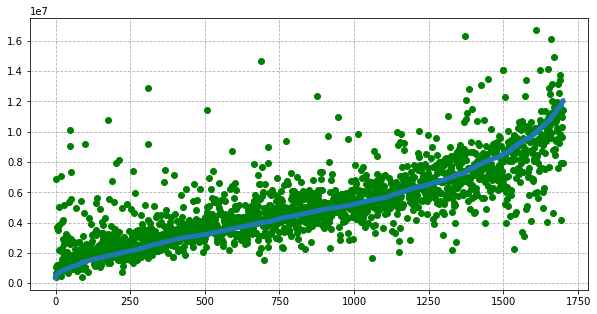

In [96]:
y_pred = model.predict(X_test)
indices = np.argsort(y_test)[:1700]

x_plt = np.arange(0, y_test[:1700].size)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_plt, y_pred[indices], 'go')
ax.plot(x_plt, y_test.iloc[indices], color='tab:blue', linewidth=5)
ax.grid(linestyle='--')

In [101]:
X_train, X_test, y_train, y_test = get_XY(bask2, col_full, random_state=123)

In [102]:
X_train.shape

(7373, 102)

In [104]:
# минимум
iso_forest = IsolationForest(random_state=92).fit_predict(np.array(y_train).reshape(-1, 1))
bask2_isoforest_ = y_train.iloc[np.where(iso_forest == 1)]
print("Итоговое кол-во объектов: {0}".format(bask2_isoforest_.size))

Итоговое кол-во объектов: 6111


In [106]:
X = X_train.loc[bask2_isoforest_.index]
y = bask2_isoforest_

In [107]:
cv_res(X, y, y.median(), iterations=1500, depth=7, lr=0.05, l2=3)

  cross-validation
RMSE:	1311096.0 +- 87470.0
MAE:	941191.0 +- 32957.0	(20.0 %)
R2:	0.662 +- 0.049
MAPE:	0.235 +- 0.014


1498

In [109]:
model = CatBoostRegressor(iterations=1500,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

eval_dataset = Pool(X_test, y_test)
model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

y_pred = model.predict(X_test)

print("====================")
print("    test-results")
print("====================")
    
print("RMSE:\t{0}".format(np.round(model.evals_result_['validation']['RMSE'][-1])))
print("MAE:\t{0}".format(np.round(model.evals_result_['validation']['MAE'][-1])))
print("R2:\t{0}".format(np.round(model.evals_result_['validation']['R2'][-1], 3)))
print("MAPE:\t{0}".format(np.round(model.evals_result_['validation']['MAPE'][-1], 3)))

    test-results
RMSE:	2989222.0
MAE:	1331351.0
R2:	0.64
MAPE:	0.31


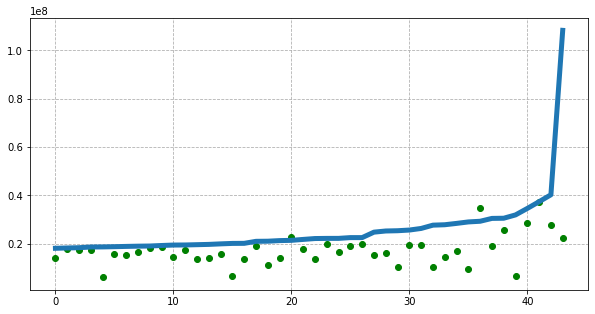

In [113]:
y_pred = model.predict(X_test)
indices = np.argsort(y_test)[1800:]

x_plt = np.arange(0, y_test[1800:].size)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_plt, y_pred[indices], 'go')
ax.plot(x_plt, y_test.iloc[indices], color='tab:blue', linewidth=5)
ax.grid(linestyle='--')